## Goals: To write a function that tells us  what 'time_id's are missing for what 'stock_id's and to show the missing time points

In [1]:
import pandas as pd
import glob
import numpy as np

from joblib import Parallel, delayed

In [2]:
# Functions required to create a dataframe with all recorded 'time_id's and 'seconds_in_bucket's for all stocks for either
# book or trade data.


def create_stock_list(str_path):
    parquet_paths = glob.glob(str_path+"/*")
    stock_list = [int(path.split("=")[1]) for path in parquet_paths]
    stock_list.sort()
    return stock_list


def create_path(stock_id, kind):
    if kind == 'book':
        path = "../raw_data/kaggle_ORVP/book_train.parquet/stock_id="+str(stock_id)
        return path
    elif kind == 'trade':
        path = "../raw_data/kaggle_ORVP/trade_train.parquet/stock_id="+str(stock_id)
        return path
    else:
        raise ValueError(f"Unknown kind: {kind}")


def create_time_points_stock(stock_id, kind):
    path = create_path(stock_id, kind)
    time_points_stock = pd.read_parquet(path, 
                                        columns=['time_id','seconds_in_bucket'])
    time_points_stock['stock_id'] = stock_id
    time_points_stock = time_points_stock[['stock_id', 'time_id', 'seconds_in_bucket']]
    time_points_stock = time_points_stock.sort_values(by=['time_id', 'seconds_in_bucket'])
    time_points_stock = time_points_stock.reset_index(drop=True)
    return time_points_stock


def create_time_points(stock_list, kind='book'):
    time_points_list = Parallel(n_jobs=-1, 
                                backend='multiprocessing', 
                                batch_size=1)(delayed(create_time_points_stock)(stock_id, kind) for stock_id in stock_list)
    time_points = pd.concat(time_points_list, ignore_index=True)
    return time_points

In [3]:
# Creates list of stocks in the directory
stock_list = create_stock_list("../raw_data/kaggle_ORVP/book_train.parquet")

# Creates a dataframe of time points for a list of stocks, in this case, all of them
time_points_book = create_time_points(stock_list, kind='book')
time_points_book

,stock_id,time_id,seconds_in_bucket
0,0,5,0
1,0,5,1
2,0,5,5
3,0,5,6
4,0,5,7
...,...,...,...
167253284,126,32767,588
167253285,126,32767,589
167253286,126,32767,590
167253287,126,32767,592


In [4]:
# Finds how many recorded time points there are for each 'stock_id' and 'time_id'
time_ids_count=time_points_book.groupby(['stock_id'])['time_id'].unique().apply(len).reset_index(name='time_ids_count')

# This is the maximum number of 'time_id's recorded for all 'stock_id's
max_time_ids=int(time_ids_count['time_ids_count'].max())
# Calculates to what extent the stock identified by 'stock_id' has fewer 'time_id's
time_ids_count['time_ids_count'] = time_ids_count['time_ids_count']-max_time_ids

# Returns only rows correspoinding to stocks that have fewer 'time_id's than the max number of 'time_id's considering all the stocks
# These are good candidates to have missing time points but there is chance these are not the only stocks with missing data points
# (because we don't know to what extent the 'time_id's for different stocks overlap)
time_ids_count[time_ids_count['time_ids_count']<0].reset_index(drop=True)

,stock_id,time_ids_count
0,13,-1
1,38,-15
2,75,-1
3,80,-10
4,100,-1


In [5]:
# Shows, for each 'stock_id' and 'time_id', how many recorded time points there are (i.e. how many timestamps 'seconds_in_bucket')
time_points_count_book = pd.crosstab(time_points_book['stock_id'],time_points_book['time_id'])
time_points_count_book

time_id,5,11,16,31,62,72,97,103,109,123,...,32736,32739,32746,32748,32750,32751,32753,32758,32763,32767
stock_id,,,,,,,,,,,,,,,,,,,,,
0,302,200,188,120,176,263,368,294,236,436,...,212,228,209,170,149,297,206,188,307,228
1,575,370,353,171,227,514,421,487,564,516,...,304,300,335,400,252,307,494,313,434,305
2,583,418,523,395,387,590,553,563,555,574,...,579,495,484,524,507,552,485,487,475,472
3,510,318,333,248,262,475,285,428,407,407,...,282,335,384,330,206,369,396,228,344,221
4,395,280,210,193,322,322,298,330,278,305,...,269,367,243,279,325,214,233,154,309,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,488,427,325,353,332,301,342,593,342,493,...,482,361,456,377,264,444,336,576,462,317
123,578,395,523,453,406,456,583,545,552,574,...,596,520,504,565,547,511,550,500,597,509
124,600,562,594,554,547,600,598,600,599,600,...,600,583,600,593,599,588,558,596,600,591


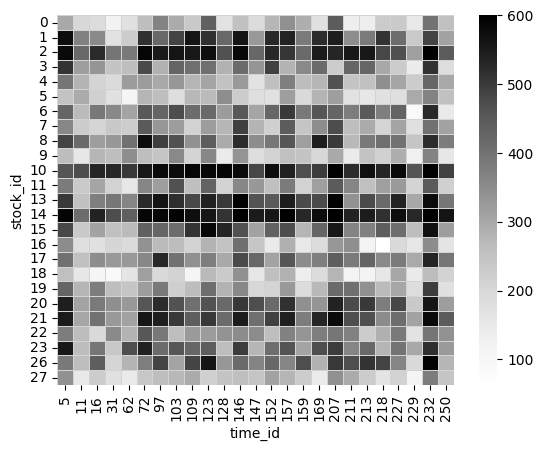

In [6]:
# The matrix provides information about how frequently sampled the stocks are
import seaborn as sns
import matplotlib.pyplot as plt

# This shows only a few 'time_id's for a few stocks. If we include too many, it is impossible to distinguish anything on the picture, 
# so this visualization is not very useful
sns.heatmap(time_points_count_book.iloc[0:25,0:25], cmap ="Greys", cbar=True, linewidths=0.5, linecolor="lightgray")
plt.show()

In [7]:
# Creates dataframe with only the stocks that are missing 'time_id's and what these 'time_id's are

def create_time_points_missing(time_points_count):
    missing_rows, missing_columns = np.where(time_points_count ==0)
    
    missing_stock_ids = time_points_count.index[missing_rows]
    missing_time_ids = time_points_count.columns[missing_columns]
    
    time_points_missing = pd.DataFrame(
        {
            'stock_id': missing_stock_ids,
            'time_id': missing_time_ids
        }
    )
    return time_points_missing

## Missing time points in book data

In [8]:
# The following time points are missing in the book data. Note that it is only stocks that we suspected were missing time point
# i.e. stocks with fewer 'time_id's than the maximum number of 'time_id's for any stock
# This means that all the other stocks share the same 'time_id's (the dataframe 'time_points_count_book' has that information)
time_points_missing_book = create_time_points_missing(time_points_count_book)
time_points_missing_book

,stock_id,time_id
0,13,32186
1,38,2458
2,38,6696
3,38,6925
4,38,8353
5,38,12423
6,38,14995
7,38,17727
8,38,18491
9,38,21431


## Missing time points in trade data

In [9]:
# Now we can do the same for trade data
time_points_trade = create_time_points(stock_list, kind='trade')
time_points_count_trade = pd.crosstab(time_points_trade['stock_id'],time_points_trade['time_id'])
time_points_missing_trade = create_time_points_missing(time_points_count_trade)

time_points_missing_trade

,stock_id,time_id
0,13,32186
1,18,8524
2,31,985
3,31,3987
4,31,5539
5,31,5629
6,31,6197
7,31,8753
8,31,8840
9,31,9208
